# 16. 트랜스포머로 만드는 대화형 챗봇 [프로젝트]

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜보자.

## 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

<table>
    <tr>
        <td><b>평가문항</b></td>
        <td><b>상세기준</b></td>
    </tr>
    <tr>
        <td>1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.</td>
        <td>공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.</td>
    </tr>
    <tr>
        <td>2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.</td>
        <td>구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.</td>
    </tr>
    <tr>
        <td>3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.</td>
        <td>한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.</td>
    </tr>
</table>

In [1]:
# 주요 라이브러리 버전 확인 및 필요한 모듈 추가
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


## **Step 1. 데이터 수집하기**

---

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용</br>

- [데이터셋 Link](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv) </br>

`Cloud shell`에서 파일을 잘 사용하기 위해 아래의 설정 수행</br>
```shell
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

In [2]:
# 데이터셋 다운로드 관련 정보 설정
file_name = 'ChatbotData.csv'
file_url = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
cache_subdir = 'data'
cache_dir = '/aiffel/aiffel/transformer_chatbot'

# 데이터셋 저장 여부를 파악할 파일 경로
## check_target_file_path값은 아래 주석과 같아진다.
### '/aiffel/aiffel/transformer_chatbot/data/ChatbotData_test.csv'
check_target_file_path = os.path.join(cache_dir, cache_subdir, file_name)

if os.path.isfile(check_target_file_path) == False:
    # 파일이 check_target_file_path에 없다면 데이터셋 다운로드
    path_to_csv = tf.keras.utils.get_file(fname=file_name, 
                                          origin=file_url, 
                                          extract=False, 
                                          cache_subdir = cache_subdir, 
                                          cache_dir=cache_dir)
    # 테스트 기준 노드의 심볼릭 링크로 완성된 파일명은 `ChatbotData .csv` 였다.
    print("데이터셋 다운로드 완료")
else:
    # 파일이 존재하면 이곳의 print()문이 수행된다.
    print("데이터셋 존재함. skip downloading..")

데이터셋 존재함. skip downloading..


`tf.keras.utils.get_file()`은 url로 존재하는 파일을 받아 원하는 로컬경로에 다운로드를 해주는 tensorflow 모듈이다.</br>

구성 arguments의 기본값은 다음과 같다.</br>

```shell
tf.keras.utils.get_file(
    fname, origin, untar=False, md5_hash=None, file_hash=None, 
    cache_subdir='datasets', hash_algorithm='auto', 
    extract=False, archive_format='auto', cache_dir=None
)
```

`fname`: 저장할 파일명</br>
`origin`: 파일출처 (보통 url패턴이 온다)</br>
`cache_dir`: 받아온 파일이 저장되는 위치</br>
             `None`일 경우, `~/.keras` 아래 경로에 저장된다.</br>
`cache_subdir`: 받아온 파일이 저장되는 sub-directory 위치</br>
                공백(`''`)으로 처리하면 sub-directory 구성을 없앨 수 있다.</br>
                
[참고링크-1](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)</br>
[참고링크-2](https://olive-su.tistory.com/127)</br>

### tensorflow.keras.get_file()관련 이슈 내역 작성

파일을 위와 같이 다운로드 받고 `pd.read_csv()`를 수행해보니 에러가 발생하였다.</br>

```text
...
ParserError: Error tokenizing data. C error: Expected 1 fields in line 31, saw 7
```

실제 파일을 확인 결과 CSV 파일형태로 저장이 되지 않았음을 확인할 수 있었다.</br>
> ChatbotData.csv를 tf.keras.utils.get_file()로 받은 파일의 내용 일부 기록
```html
<!DOCTYPE html>
<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"  data-a11y-animated-images="system">
  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">
...
```

확인 결과, file url 정보가 아래와 같아야 함을 알 수있었다.</br>
- `'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'`

만약 아래와 같은 경로로 url이 설정되면 xml 파일 형태로 저장이 되어버려 CSV read를 할 수 없었다.</br>
- `'https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv'`

In [3]:
# 파일이 CSV이므로, 데이터를 pandas로 로드하여 샘플을 확인
## check_target_file_path 정보는 아래와 같음
### '/aiffel/aiffel/transformer_chatbot/data/ChatbotData_test.csv'
train_data = pd.read_csv(check_target_file_path)
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# 데이터 샘플 개수 확인
print(f"챗봇 샘플 개수: {len(train_data)}")

챗봇 샘플 개수: 11823


In [5]:
# 데이터 샘플에서 Null 값 확인
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


## **Step 2. 데이터 전처리하기**

---

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

챗봇 샘플이 아주 많지 않으므로 전체 데이터를 모두 사용하기로 한다.</br>
`MAX_SAMPLES`는 전체 데이터 길이로 설정한다.

In [6]:
# 사용할 샘플의 최대 개수 설정 및 확인
MAX_SAMPLES = len(train_data)
print(MAX_SAMPLES)

11823


In [7]:
# 공백과 특수문자를 전처리하는 함수를 선언
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "출석체크 하세요." => "출석체크 하세요 ."와 같이
  # '하세요'와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글, 영어, 숫자, "?", "!", "."를 제외한 모든 문자를 공백인  '로 대체합니다.
  # 참고: https://signing.tistory.com/74
  sentence = re.sub(r"[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

위 함수를 사용하여 질문 데이터와 답변 데이터를 모두 전처리하자.

In [8]:
# 질문 데이터 전처리
questions = []

for sentence in tqdm(train_data['Q'], desc="데이터셋의 Q 컬럼 전처리 중..."):
    questions.append(preprocess_sentence(sentence))

# 답변 데이터 전처리
answers = []

for sentence in tqdm(train_data['A'], desc="데이터셋의 A 컬럼 전처리 중..."):
    answers.append(preprocess_sentence(sentence))
    

print("데이터 전처리 완료!")

데이터셋의 A 컬럼 전처리 중...: 100%|██████████| 11823/11823 [00:00<00:00, 111040.28it/s]

데이터 전처리 완료!


데이터 전처리가 잘 수행되었는지 확인을 위해 상위 5개 데이터를 출력해보자.

In [9]:
print(f"Q 데이터 5개: {questions[:5]}")
print(f"A 데이터 5개: {answers[:5]}")

Q 데이터 5개: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
A 데이터 5개: ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## **Step 3. SubwordTextEncoder 사용하기**

---

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [10]:
print("SubwordTextEncoder 작업중...")

# start_time을 체크
start_time = time.time()

# SubwordTextEncoder 사용하여 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# end_time을 체크
end_time = time.time()

# SubwordTextEncoder 작동 소요시간을 측정, second 값 반환
spend_time = end_time - start_time

print(f"작업완료. 소요시간: {spend_time} sec")


SubwordTextEncoder 작업중...
작업완료. 소요시간: 12.486371040344238 sec


Encoder-Decoder 모델 계열은 시작 토큰 `SOS`과 종료 토큰 `EOS`가 필요하다.</br>
해당 **토큰들은 디코더의 입력요소**로 사용된다.</br>

따라서, 토큰들도 단어 집합에 포함시킬 필요가 있다.

In [11]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("토큰에 고유한 정수 부여 완료")

# 종료 토큰(END_TOKEN)의 단어장 인덱스를 
# 시작 토큰(START_TOKEN)의 인덱스와 겹치지 않게 하기 위해서 + 1을 해줌

토큰에 고유한 정수 부여 완료


In [12]:
# 두 토큰 추가를 고려한 VOCAB_SIZE 설정
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print("단어장 크기(VOCAB_SIZE) 산정 완료")

단어장 크기(VOCAB_SIZE) 산정 완료


In [13]:
# 토큰의 번호와 단어 집합의 크기 확인
print(f"시작 토큰 번호 : {START_TOKEN}")
print(f"종료 토큰 번호 : {END_TOKEN}")
print(f"단어 집합의 크기 : {VOCAB_SIZE}")

시작 토큰 번호 : [8162]
종료 토큰 번호 : [8163]
단어 집합의 크기 : 8164


In [14]:
# 임의 5번째 샘플에 대해서 정수 인코딩, 토큰 디코딩 작업 수행
# 각 수행과정의 결과확인
## 디코더의 경우 원 답변과의 차이도 비교함
q_int_encode = tokenizer.encode(questions[4])
a_int_encode = tokenizer.encode(answers[4])
print('정수 인코딩 후의 5번째 질문 샘플: {}'.format(q_int_encode))
print('정수 인코딩 후의 5번째 답변 샘플: {}'.format(a_int_encode))
print("====")
# 각 고유한 정수 시퀀스를 토큰으로 변환
q_token_decode = tokenizer.decode(q_int_encode)
a_token_decode = tokenizer.decode(a_int_encode)
print(f"토큰 디코딩 후의 5번째 질문 샘플: {q_token_decode}")
print(f"토큰으로 가지고 있던 5번째 질문 샘플: {questions[4]}")
print(f"토큰 디코딩 후의 5번째 답변 샘플: {a_token_decode}")
print(f"토큰으로 가지고 있던 5번째 답변 샘플: {answers[4]}")

정수 인코딩 후의 5번째 질문 샘플: [8018, 8018, 8014, 7938, 4181]
정수 인코딩 후의 5번째 답변 샘플: [981, 2296, 1491, 2180, 5461, 50, 1]
====
토큰 디코딩 후의 5번째 질문 샘플: ppl 심하네
토큰으로 가지고 있던 5번째 질문 샘플: ppl 심하네
토큰 디코딩 후의 5번째 답변 샘플: 눈살이 찌푸려지죠 .
토큰으로 가지고 있던 5번째 답변 샘플: 눈살이 찌푸려지죠 .


실제 데이터셋에서 단어장의 길이가 40인 경우가 없었다.</br>
이에 `MAX_LENGTH`를 20으로 재조정하였다.</br>

재조정 기준은 기존 테스트 길이의 절반으로 하였다.

In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 설정 및 확인
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [16]:
# 훈련 데이터셋 (질문, 답변)을 입력하면 다음을 수행하는 함수 선언
## 1. 정수 인코딩 & 토큰 추가(시작 토큰, 종료 토큰)
## 2. MAX_LENGTH 초과하는 문장 데이터셋으로 사용하지 않음
## 3. MAX_LENGTH 길이 만큼 모든 데이터셋을 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

print("tokenize_and_filter() 선언 완료!")

tokenize_and_filter() 선언 완료!


In [17]:
# 단어장 크기와 샘플의 개수 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11792
필터링 후의 답변 샘플 개수: 11792


훈련 속도 빨라지도록 dataset을 조정한다.</br>
이때, 디코더의 입력과 실제 값(레이블)을 정의하기 위해,
교사 강요(Teacher Forcing)이라는 언어 모델 훈련 기법을 사용한다.

In [18]:
# 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용
# 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## **Step 4. 모델 구성하기**

---

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [19]:
## Positional Maxtrix 구현하기
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  # 단어 벡터 간 유사도를 dot product 연산으로 구한다; matmul_qk --> 단어 벡터 간 유사도를 의미
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  # 단어 벡터간 유사도를 0 ~ 1로 normalization
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")
## 노드 기준; 어텐션을 수행한다고 하면, scaled-dot-product attention 수행을 의미함

슝=3


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  # 병렬 연산을 위한 입력 벡터의 헤드 수를 설정하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # [[YOUR CODE]]
    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [22]:
# 패딩 마스킹 기능을 가지는 함수 선언
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [23]:
# 록어헤드 마스킹 기능을 가지는 함수 선언
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


- RNN은 순차적으로 문장을 단어별 검색하니까 이러한 기능이 필요없음
- 트랜스포머의 경우 전체 문장이 문장 행렬로 들어옴
    - 문장에서의 위치에 관계없이 모든 단어를 참고하여 다음에 올 단어를 예측할 수 있다.
        - 록어헤드 마스킹을 적용하면, 자신보다 다음에 나올 단어를 참고하지 않게 된다.
            - Query 단어(자신) 뒤에 나오는 Key 단어(다음 단어)들에 대해 마스킹

In [24]:
# 트랜스포머의 인코더 설계 - encoder layer part
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [25]:
# 인코더 함수 선언; Transformer의 인코더
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

## 논문에서 encoder의 num_layers의 값은 6 이었다.

슝=3


In [26]:
# 트랜스포머의 디코더 설계 - decoder layer part
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [27]:
# Transformer의 디코더는 embedding layer와 positional encoding을 연결하고,
# 사용자가 원하는 만큼 디코더 층을 쌓아야 완성된다. (num_layers)
## num_layers는 Transformer encoder의 값과 동일하면 되는 것 같다.
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

# 논문에서는 역시 num_layers를 6으로 설정하였지만 실습에서는 좀 더 적을 예정

슝=3


In [28]:
# 앞서 사용한 인코더 함수, 디코더 함수를 사용하여 Transformer 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


모델 생성하여 과정 내역(`summary()`)을 확인하자.

In [29]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
## num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터
### 논문 값 (num_layers=6, d-Model=512)보다 작게 설정하여 훈련 속도 증가시킴
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [30]:
# 레이블 시퀀스에 padding이 적용되어 있다.
# 그래서, loss 계산할 때, paading mask를 적용해야 한다.
# 손실함수 선언
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


딥러닝 모델학습 시 `learning rate`는 매우 중요한 하이퍼파라미터이다</br>
- 최근 Trend: 모델 학습초기에 learning rate를 급격히 높인다.
    - 이후 train step이 진행됨에 따라 learning rate를 서서히 낮추어 가면서 안정적으로 수렴하게 한다.
    
이런 방식을 커스텀 학습률 스케줄링 이라고 한다.

In [31]:
# 논문에서 사용한 공식을 참고하여 커스텀 학습률 스케줄러가 적용된 adam optimizer 클래스를 선언
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

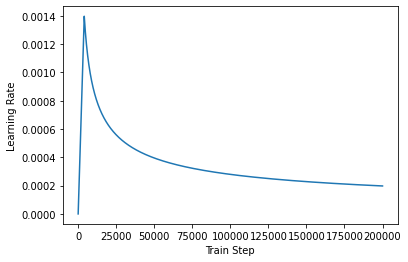

In [32]:
# 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해보기.
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [34]:
# 모델 학습 진행하기; 10 epoch으로 설정하여 테스트
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 14s 39ms/step - loss: 2.9643 - accuracy: 0.0619
Epoch 2/10
185/185 [==============================] - 7s 38ms/step - loss: 2.3962 - accuracy: 0.1015
Epoch 3/10
185/185 [==============================] - 7s 39ms/step - loss: 2.0423 - accuracy: 0.1036
Epoch 4/10
185/185 [==============================] - 7s 39ms/step - loss: 1.8900 - accuracy: 0.1107
Epoch 5/10
185/185 [==============================] - 7s 39ms/step - loss: 1.7742 - accuracy: 0.1172
Epoch 6/10
185/185 [==============================] - 7s 39ms/step - loss: 1.6523 - accuracy: 0.1266
Epoch 7/10
185/185 [==============================] - 7s 39ms/step - loss: 1.5169 - accuracy: 0.1386
Epoch 8/10
185/185 [==============================] - 7s 39ms/step - loss: 1.3678 - accuracy: 0.1545
Epoch 9/10
185/185 [==============================] - 7s 39ms/step - loss: 1.2050 - accuracy: 0.1721
Epoch 10/10
185/185 [==============================] - 7s 39ms/step - loss: 1.0374 - accur

## **Step 5. 모델 평가하기**

---

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

예측(inference) 단계의 기본 과정은 다음과 같다.</br>

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [35]:
# 위에서 설명한 예측 과정을 수행하는 함수 선언
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [36]:
# 임의의 문장을 입력하면 decoder_inference()로 챗봇의 대답을 획득하기
# 위 기능을 수행하는 함수 선언
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 1**

In [37]:
sentence_kr = '영화 볼래?'

sentence_generation(sentence_kr)

입력 : 영화 볼래?
출력 : 먼저 연락을 해보세요 .


'먼저 연락을 해보세요 .'

**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 2**

In [38]:
sentence_kr = '고민이 있어.'

sentence_generation(sentence_kr)

입력 : 고민이 있어.
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 3**

In [39]:
sentence_kr = '너무 화가나'

sentence_generation(sentence_kr)

입력 : 너무 화가나
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 4**

In [40]:
sentence_kr = 'PC방 갈래?'

sentence_generation(sentence_kr)

입력 : PC방 갈래?
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 5**

In [41]:
sentence_kr = '게임하고싶당'

sentence_generation(sentence_kr)

입력 : 게임하고싶당
출력 : 얼른 주무세요 .


'얼른 주무세요 .'

**임의의 문장을 입력해서 챗봇의 대답을 얻어보기 - 6**

In [42]:
sentence_kr = '게임 레스고'

sentence_generation(sentence_kr)

입력 : 게임 레스고
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

## 개인적인 생각

학습을 10회만 수행해서 그런지, 답변이 어색한 경우도 있었다.</br>
그리고 특정 표현(`레스고`)에 대해 단어 사전이 정의되어 있지 않아, 답변이 이상하게 느껴지는 경우도 있었다.</br>

추후 학습을 늘려서 수행해보거나, 단어 사전을 좀 더 심도있게 구성하여 테스트를 해보면 좀 더 그럴듯한 챗봇이 되지 않을까 생각한다.